# Оценка результатов А/В-теста

Задача исследования — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

В ходе работы необходимо оценить корректность проведения теста и проанализировать его результаты. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платежная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Загрузка данных и изучение общей информации

Загрузим датасеты, подготовим описание данных и изучим основную информацию о датасетах (типы переменных в каждом столбце, количество пропусков и полных дубликатов строк, описательные статистики по числовым переменным, значения категориальных переменных).

Импортируем все необходимые библиотеки для работы с данными.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as st
import plotly.graph_objects as go
import math as mth
import scipy.stats as stats

from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from scipy import stats as st
from matplotlib import pyplot as plt
from scipy import stats as st

import plotly.io as pio
pio.renderers.default = 'png'
pio.renderers['png'].scale = 1.2

Загрузим предоставленные датасеты. На этом же этаже приведем столбцы с датами к типу `datetime`.

In [2]:
final_ab_events = pd.read_csv(
    'https://code.s3.yandex.net/datasets/final_ab_events.csv', parse_dates=['event_dt']
)

ab_project_marketing_events = pd.read_csv(
    'https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt']
)

final_ab_new_users = pd.read_csv(
    'https://code.s3.yandex.net/datasets/final_ab_new_users.csv', parse_dates=['first_date']
)

final_ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

Выведем первые 5 строк для каждого датасета и приведем описание данных.

In [3]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [4]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [5]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [6]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

Посмотрим всю информацию о датафреймах. Для этого воспользуемся ранее созданной функцией.

In [67]:
def describe_all(data, unique_vals=20):
    '''Функция, которая выводит подробное описание данных датафрейма.
    
    Функция принимает на вход датафрейм и выводит информацию о датафрейме, описание переменных,
    количество полных дубликатов строк, а также количество уникальных значений в каждом из столбцов,
    содержащих переменные типа 'object'. Количество уникальных значений можно указать во втором параметре функции
    (по умолчанию 20).
    '''
    
    print('Информация о датафрейме')
    data.info()
    print('-'*20)
    print()
    
    print('Описание датафрейма')
    display(data.describe())
    print('-'*20)
    print()
    
    print('Количество полных дубликатов строк:', data.duplicated().sum())
    print('-'*20)
    print()
    
    for i in data.select_dtypes(include=['object']).columns:
        print(f'Количество уникальных значений в столбце {i}: {data[i].nunique()}')
        if data[i].nunique() <= unique_vals:
            print(f'Список уникальных значений {data[i].unique()}')
        print('- '*10)


In [68]:
describe_all(final_ab_events)

Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12237 entries, 0 to 12236
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       12237 non-null  object        
 1   event_dt      12237 non-null  datetime64[ns]
 2   event_name    12237 non-null  object        
 3   details       1601 non-null   float64       
 4   first_date    12237 non-null  datetime64[ns]
 5   group         12237 non-null  object        
 6   event_dt_day  12237 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 764.8+ KB
--------------------

Описание датафрейма


,details
count,1601.000000
mean,22.497808
std,66.204023
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


--------------------

Количество полных дубликатов строк: 0
--------------------

Количество уникальных значений в столбце user_id: 1880
- - - - - - - - - - 
Количество уникальных значений в столбце event_name: 4
Список уникальных значений ['purchase' 'product_cart' 'product_page' 'login']
- - - - - - - - - - 
Количество уникальных значений в столбце group: 2
Список уникальных значений ['A' 'B']
- - - - - - - - - - 
Количество уникальных значений в столбце event_dt_day: 23
- - - - - - - - - - 


Столбец `details` содержит пропуски. В таблице содержатся данные по 58703 пользователям. Всего видов событий 4: `purchase` `product_cart` `product_page` `login`

In [69]:
describe_all(ab_project_marketing_events)

Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
--------------------

Описание датафрейма


C:\Users\darkt\AppData\Local\Temp\ipykernel_58392\3630125438.py:16: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

C:\Users\darkt\AppData\Local\Temp\ipykernel_58392\3630125438.py:16: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25 00:00:00,2021-01-03 00:00:00
freq,1,4,1,1
first,NaN,NaN,2020-01-25 00:00:00,2020-02-07 00:00:00
last,NaN,NaN,2020-12-30 00:00:00,2021-01-07 00:00:00


--------------------

Количество полных дубликатов строк: 0
--------------------

Количество уникальных значений в столбце name: 14
Список уникальных значений ['Christmas&New Year Promo' "St. Valentine's Day Giveaway"
 "St. Patric's Day Promo" 'Easter Promo' '4th of July Promo'
 'Black Friday Ads Campaign' 'Chinese New Year Promo'
 'Labor day (May 1st) Ads Campaign' "International Women's Day Promo"
 'Victory Day CIS (May 9th) Event' 'CIS New Year Gift Lottery'
 'Dragon Boat Festival Giveaway' "Single's Day Gift Promo"
 'Chinese Moon Festival']
- - - - - - - - - - 
Количество уникальных значений в столбце regions: 6
Список уникальных значений ['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'
 'EU, CIS, APAC' 'CIS']
- - - - - - - - - - 


Посмотрим, в каких регионах проводились рекламные компании.

In [70]:
regions = []

for i in ab_project_marketing_events.regions.unique():
    regions += (i.split(', '))
    
list(set(regions))

['EU', 'CIS', 'APAC', 'N.America']

Рекламные компании проводились в 4 регионах: `EU`, `N.America`, `APAC`, `CIS`. В датафрейме содежатся данные по 14 рекламным компаниям.

In [71]:
describe_all(final_ab_new_users)

Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56470 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     56470 non-null  object        
 1   first_date  56470 non-null  datetime64[ns]
 2   region      56470 non-null  object        
 3   device      56470 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.2+ MB
--------------------

Описание датафрейма


C:\Users\darkt\AppData\Local\Temp\ipykernel_58392\3630125438.py:16: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,user_id,first_date,region,device
count,56470,56470,56470,56470
unique,56470,15,4,4
top,D72A72121175D8BE,2020-12-21 00:00:00,EU,Android
freq,1,6290,42340,25161
first,NaN,2020-12-07 00:00:00,NaN,NaN
last,NaN,2020-12-21 00:00:00,NaN,NaN


--------------------

Количество полных дубликатов строк: 0
--------------------

Количество уникальных значений в столбце user_id: 56470
- - - - - - - - - - 
Количество уникальных значений в столбце region: 4
Список уникальных значений ['EU' 'N.America' 'APAC' 'CIS']
- - - - - - - - - - 
Количество уникальных значений в столбце device: 4
Список уникальных значений ['PC' 'Android' 'iPhone' 'Mac']
- - - - - - - - - - 


В датафрейме содержатся данные по 61733 пользователям. Всего регионов 4: `EU`, `N.America`, `APAC`, `CIS`. Устройств, с которых происходила регистрация пользователя содержится 4 вида: `PC` `Android` `iPhone` `Mac`. Все значения `user_id` уникальны.

In [72]:
describe_all(final_ab_participants)

Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3869 entries, 0 to 6350
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3869 non-null   object
 1   group    3869 non-null   object
 2   ab_test  3869 non-null   object
dtypes: object(3)
memory usage: 120.9+ KB
--------------------

Описание датафрейма


,user_id,group,ab_test
count,3869,3869,3869
unique,3869,2,1
top,D1ABA3E2887B6A73,A,recommender_system_test
freq,1,2237,3869


--------------------

Количество полных дубликатов строк: 0
--------------------

Количество уникальных значений в столбце user_id: 3869
- - - - - - - - - - 
Количество уникальных значений в столбце group: 2
Список уникальных значений ['A' 'B']
- - - - - - - - - - 
Количество уникальных значений в столбце ab_test: 1
Список уникальных значений ['recommender_system_test']
- - - - - - - - - - 


Уникальных значений `user_id` 16666, всего записей `user_id` 18268. Это говорит о том, что в данном столбце имеются дубликаты.

In [73]:
final_ab_participants.groupby(['ab_test', 'group'], as_index=False)['user_id'].count()

,ab_test,group,user_id
0,recommender_system_test,A,2237
1,recommender_system_test,B,1632


В датаферйме содержатся данные по 16666 пользователям. По две группы (А и В) для каждого теста (`interface_eu_test` и `recommender_system_test`). 

## Предобработка данных

### Обработка пропусков

В столбце `details` таблицы `final_ab_events` содержатся пропуски. Выведем количество ненулевых значений в данном столбце для каждого из событий.

In [14]:
(
    final_ab_events.groupby('event_name').agg({'user_id': 'count', 'details': 'count'})
    .rename(columns=({'user_id': 'total_count', 'details': 'notna_count'}))
)

,total_count,notna_count
event_name,,
login,189552,0
product_cart,62462,0
product_page,125563,0
purchase,62740,62740


Пропуски содержатся для всех событий, за исключением `purchase`, поскольку по ним отсутствует дополнительная информация. Пропуски относятся к категории MNAR (отсутствуют не случайно), их обработка не требуется.

## Оценка корректности проведения теста

### Проверка на соответстиве требованиям технического задания

Проверим данные на соответствие техническому заданию.

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платежная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

Посмотрим, за какой период содержится информация в датасете `final_ab_new_users`.

In [15]:
final_ab_new_users.first_date.agg(['min', 'max'])

min   2020-12-07
max   2020-12-23
Name: first_date, dtype: datetime64[ns]

По условиям ТЗ нам нужны пользователи, зарегистрированные в период с 2020-12-07 по 2020-12-21. Удалим из датасета пользователей, дата регистрации которых не попадает в указанный период.

In [16]:
final_ab_new_users = final_ab_new_users.query('first_date >= "2020-12-07" & first_date <= "2020-12-21"')

final_ab_new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


Оставим среди участников теста в датасете `final_ab_participants` только тех пользователей, которые зарегистрировались в период с 2020-12-7 по 2020-12-21.

In [17]:
final_ab_participants = final_ab_participants[final_ab_participants['user_id'].isin(final_ab_new_users['user_id'])]

final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


Посмотрим, за какой период содержится информация в датасете `final_ab_events`.

In [18]:
final_ab_events['event_dt'].agg(['min', 'max'])

min   2020-12-07 00:00:33
max   2020-12-30 23:36:33
Name: event_dt, dtype: datetime64[ns]

По условиям ТЗ дата остановки теста: 2021-01-04. Тест остановлен 2020-12-30 - раньше запланированной даты.

Каждому пользователю из датасета `final_ab_participants` добавим информацию о регионе из датасета `final_ab_new_users`. И проверим, соответствует ли доля пользователей из Европы условиям ТЗ.

In [19]:
final_ab_participants_reg = final_ab_participants.merge(final_ab_new_users[['region', 'user_id']], on='user_id', how='left')

final_ab_participants_reg

,user_id,group,ab_test,region
0,D1ABA3E2887B6A73,A,recommender_system_test,EU
1,A7A3664BD6242119,A,recommender_system_test,EU
2,DABC14FDDFADD29E,A,recommender_system_test,EU
3,04988C5DF189632E,A,recommender_system_test,EU
4,482F14783456D21B,B,recommender_system_test,EU
...,...,...,...,...
17261,1D302F8688B91781,B,interface_eu_test,EU
17262,3DE51B726983B657,A,interface_eu_test,EU
17263,F501F79D332BE86C,A,interface_eu_test,EU
17264,63FBE257B05F2245,A,interface_eu_test,EU


Согласно ТЗ, в тест должно быть отобрано 15% новых пользователей из региона EU. Проверим, выполняется ли данное условие.

In [20]:
(
    final_ab_participants_reg.query('ab_test == "recommender_system_test" & region =="EU"').shape[0] /
    final_ab_new_users.query('region =="EU"').shape[0]
)

0.15

Условие ТЗ выполняется.

По условиям ТЗ ожидаемое количество участников теста: 6000. Проверим, выполняется ли данное условие.

In [21]:
final_ab_participants_reg.query('ab_test == "recommender_system_test"').shape[0]

6701

Условие ТЗ выполняется. Однако также стоит учитывать, что не все участников теста совершали действия.

**Вывод:** формально все требования ТЗ, за исключением даты окончания теста, выполняются. Однако часть пользователей, походящих под заданные условия могут не совершить целевых действий, могут участвовать в тестовой группе конкурирующего теста (то есть быть подверженным влиянию изменений конкурирующего теста).

Однако окончание теста раньше запланированной даты (установленной с учетом набора необходимой аудитории и минимального обнаруживаемого изменения показателей)  может сделать результаты теста недействительными (не все зарегистрированные пользователи прожили требуемые 14 дней к моменту окончания теста, что сокращает его аудиторию).

### Проверка времени проведения теста

Проверим время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.

Выведем маркетинговые события, которые проводились в Европе.

In [22]:
ab_project_marketing_events[ab_project_marketing_events['regions'].str.contains('EU')].sort_values('start_dt')

,name,regions,start_dt,finish_dt
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Посмотрим период проведения теста

In [23]:
final_ab_events['event_dt'].agg(['min', 'max'])

min   2020-12-07 00:00:33
max   2020-12-30 23:36:33
Name: event_dt, dtype: datetime64[ns]

В период с 2020-12-25 по 2020-12-30 на поведение пользователей может оказывать влияние рекламная компания Christmas&New Year Promo.

### Подготовка данных для проведения анализа

Подготовим данные для проведения анализа. Проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.

Поскольку нас интересуют только пользователи, LTV которых составляет 14 дней с момента регистрации, из датасета `final_ab_participants` исключим пользователей, которые зарегистрировались менее чем за 14 дней до окончания теста.

In [24]:
final_ab_participants = final_ab_participants[final_ab_participants['user_id'].isin(
    final_ab_new_users[final_ab_new_users['first_date'] <= (final_ab_events['event_dt'].max() - timedelta(13))].user_id
)]

In [25]:
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
18259,96304D5B53694096,A,interface_eu_test
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test


Проверим, есть ли пользователи теста recommender_system_test, которые попали одновременно в группу A и B. Для этого сгруппируем датафрейм по `user_id` и найдем количество пользователелей, для которых количество групп больше одной.

In [26]:
(final_ab_participants.query('ab_test == "recommender_system_test"').groupby('user_id')['group'].nunique() > 1).sum()

0

Такие пользователи отсутствуют. Также проверим, есть ли пользователи, которые приситствуют в тесте recommender_system_test и в тестовой группе interface_eu_test.

In [27]:
final_ab_participants[
    (final_ab_participants['ab_test'] == 'recommender_system_test') &
    (
        final_ab_participants['user_id'].isin(final_ab_participants.query('ab_test == "interface_eu_test" and group == "B"')
                                              .user_id)
    )
].user_id.nunique()

557

Таких пользователей 557. Также исключим их их датасета, т.к. изменения в конкурирующем тесте может оказать влияние на поведение пользователей, которые находятся в контрольной или тестовой группе теста recommender_system_test.

In [28]:
final_ab_participants = final_ab_participants[
    ~((final_ab_participants['ab_test'] == 'recommender_system_test') &
    (final_ab_participants['user_id']
     .isin(final_ab_participants.query('ab_test == "interface_eu_test" and group == "B"').user_id))
     )]

In [29]:
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
18259,96304D5B53694096,A,interface_eu_test
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test


Все пересечения исследованы. Оставим в датасете `final_ab_participants` только пользователей, участвующих в recommender_system_test.

In [30]:
final_ab_participants = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']

In [31]:
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
6695,94786EB776B45914,A,recommender_system_test
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Также исключим из датасета `final_ab_participants` всех пользователей, кроме пользователей из Европы.

In [32]:
final_ab_participants = (
    final_ab_participants[final_ab_participants['user_id'].isin(final_ab_new_users.query('region == "EU"')['user_id'])]
)

In [33]:
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
...,...,...,...
6345,A23B0A7FFF375BFF,B,recommender_system_test
6347,91C3969B8A72B908,B,recommender_system_test
6348,E26F13A65CEAC6EA,A,recommender_system_test
6349,95401934D6D6D4FC,B,recommender_system_test


Найдем участников теста recommender_system_test, которые не совершали событий и посмотрим на их распределение между группами теста. Для этого создадим датафрейм `no_event_users`, в котором будут храниться все пользователи, которые не совершали действий за время проведения теста.

In [34]:
no_event_users = (
    final_ab_participants.query('ab_test == "recommender_system_test"').merge(final_ab_events, how='left', on='user_id')
    .query('event_name.isna()')
)

In [35]:
no_event_users

,user_id,group,ab_test,event_dt,event_name,details
26,482F14783456D21B,B,recommender_system_test,NaT,NaN,NaN
41,057AB296296C7FC0,B,recommender_system_test,NaT,NaN,NaN
48,E9FA12FAE3F5769C,B,recommender_system_test,NaT,NaN,NaN
49,FDD0A1016549D707,A,recommender_system_test,NaT,NaN,NaN
50,547E99A7BDB0FCE9,A,recommender_system_test,NaT,NaN,NaN
...,...,...,...,...,...,...
14888,C5E1BD2400840B30,B,recommender_system_test,NaT,NaN,NaN
14889,EA29547AB3C0CB9C,B,recommender_system_test,NaT,NaN,NaN
14905,9A44E27079666291,B,recommender_system_test,NaT,NaN,NaN
14906,9C2D0067A991213E,B,recommender_system_test,NaT,NaN,NaN


Посчитаем количество пользователей не совершавших действий за время проведения тестирования в разрезе групп.

In [36]:
t = (
    no_event_users.groupby('group')
    .agg({'user_id': 'count'})
    .merge(final_ab_participants.groupby('group')['user_id'].count().to_frame(), on='group')
    .rename(columns=({'user_id_x': 'no_ev_users_count', 'user_id_y': 'total_users_count'}))
)
    
t['share'] = (t['no_ev_users_count'] / t['total_users_count']).round(2)

t

,no_ev_users_count,total_users_count,share
group,,,
A,916,2237,0.41
B,1073,1632,0.66


В группе В доля пользователей, не совершавших действий больше, чем в группе А на 21%.

Посмотрим, как проводился набор пользователей по дням.

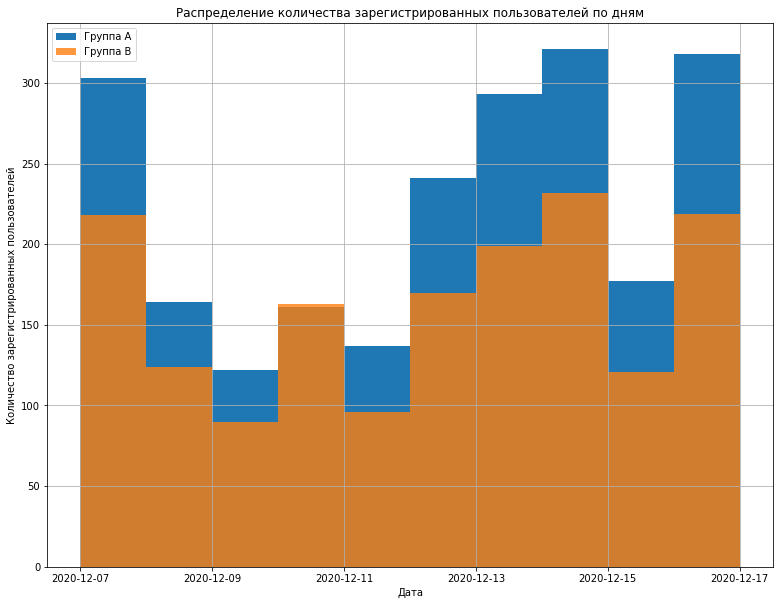

In [37]:
t = final_ab_new_users.merge(final_ab_participants, how='right', on='user_id')
t.query('group == "A"')['first_date'].hist(figsize=(13,10), bins=10, label='Группа A')
t.query('group == "B"')['first_date'].hist(figsize=(13,10), bins=10, label='Группа B', alpha=0.8)

plt.xlabel('Дата')
plt.ylabel('Количество зарегистрированных пользователей')
plt.title('Распределение количества зарегистрированных пользователей по дням')
plt.legend()
plt.show()

Распределение количества регистраций пользователей группы А аналогично распределению количества регистраций пользователей группы В. В целом для группы А практически каждый день регистрировалось больше пользователей.

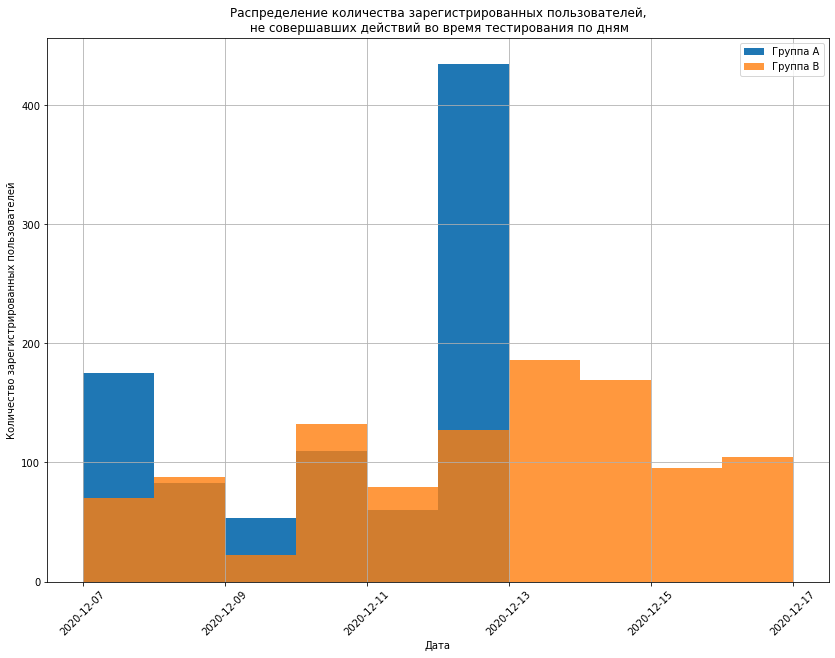

In [38]:
no_event_users.merge(final_ab_new_users, on='user_id', how='left')\
.query('group == "A"')['first_date'].hist(figsize=(13,10), bins=6, label='Группа A')

no_event_users.merge(final_ab_new_users, on='user_id', how='left')\
.query('group == "B"')['first_date'].hist(figsize=(14,10), bins=10, label='Группа В', alpha=0.8)

plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Количество зарегистрированных пользователей')
plt.title('Распределение количества зарегистрированных пользователей,\n не совершавших действий во время тестирования по дням')
plt.legend()
plt.show()

Отметим, что в группу А пользователи, которые не совершали действий регистрировались с 2020-12-07 по 2020-12-12, причем за последнюю дату таких пользвователей зарегистрировалось большое количество.
В группу В пользователи, которые не совершали действий регистрировались на протяжении всего времени набора: с 2020-12-07 по 2020-12-16.

В датасете `final_ab_events` оставим только действия для пользователей из датасета `final_ab_participants`.

In [39]:
final_ab_events = final_ab_events[final_ab_events['user_id'].isin(final_ab_participants['user_id'])]

In [40]:
final_ab_events

,user_id,event_dt,event_name,details
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99
74,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99
...,...,...,...,...
439346,69924C768EE3374C,2020-12-29 23:27:00,login,NaN
439774,016F758EB5C5A5DA,2020-12-29 07:51:00,login,NaN
439809,7DC0F01827866E41,2020-12-29 08:43:44,login,NaN
440281,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,NaN


По условиям ТЗ ожидаемый эффект необходимо зафиксировать за 14 дней с момента регистрации пользователя. В датасете `final_ab_events` оставим только те действия, время совершения которых составляет не более 14 дней с момена регистрации пользователя.

In [41]:
final_ab_events = final_ab_events.merge(final_ab_new_users[['user_id', 'first_date']], how='left', on='user_id')
final_ab_events = final_ab_events[(final_ab_events['event_dt'] - timedelta(14)) < final_ab_events['first_date']]

In [42]:
final_ab_events

,user_id,event_dt,event_name,details,first_date
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07
...,...,...,...,...,...
12934,A13A9A1B54CAEB4B,2020-12-29 14:59:38,login,NaN,2020-12-17
12935,1095D37412647DA1,2020-12-29 02:27:25,login,NaN,2020-12-17
12936,9F4F58990EAB3DFE,2020-12-29 17:39:13,login,NaN,2020-12-17
12937,14AB9446E8FD3584,2020-12-29 00:09:48,login,NaN,2020-12-17


Вычислим, какое количество пользователей мы потеряли в процессе проверки качества теста и подготовки данных.

In [43]:
print('В процессе проверки качества теста и подготовки данных утрачено {:.2%} пользователей'.format(
    (1 - final_ab_participants.shape[0] / final_ab_participants_reg.query('ab_test == "recommender_system_test"').shape[0])
)
     )

В процессе проверки качества теста и подготовки данных утрачено 42.26% пользователей


Вычислим долю пользователей из Европы среди всех пользователей, зарегистрировавшихся в период с 2020-12-07 по 2020-12-16 (за 14 дней до окончания теста). Также найдем количество участников теста.

In [44]:
print(
    'Доля участников теста из Европы среди всех пользователей, зарегистрировавшихся\
 в период с 2020-12-07 по 2020-12-16: {:.2%}'
    .format(
        final_ab_participants.shape[0] / 
        final_ab_new_users[final_ab_new_users['first_date'] <= datetime(2020, 12, 16)].shape[0]
    )
)

print('Общее количество участников теста:', final_ab_participants.shape[0])

Доля участников теста из Европы среди всех пользователей, зарегистрировавшихся в период с 2020-12-07 по 2020-12-16: 10.79%
Общее количество участников теста: 3869


По итогам проверки качества данных и их подготовки для проведения для анализа, можно сделать вывод, что требования ТЗ не выполняются.

Проверим равномерность распределения пользователей по тестовым группам и правильность их формирования.

In [45]:
sh_users_group = final_ab_participants['group'].value_counts(normalize=True).to_frame().rename(columns=({'group': 'share'}))

In [46]:
sh_users_group

,share
A,0.578186
B,0.421814


In [47]:
print('Разница между группами A и B составляет {:.2%}'.format(sh_users_group.iloc[0, 0] - sh_users_group.iloc[1, 0]))

Разница между группами A и B составляет 15.64%


In [48]:
final_ab_participants.groupby('group')['user_id'].count().to_frame().rename(columns=({'user_id':'user_count'}))

,user_count
group,
A,2237
B,1632


Пользователи распределены по группам неравномерно: 2237 в группе А и 1632 в группе В. Разница между группами A и B составляет 15.64%.

## Исследовательский анализ данных

Проверим, одинаково ли распределено количество событий на пользователя в выборках. Для этого создадим датафрейм `count_events_by_users`, в котором для каждого пользователя будет указана группа теста и количество действий.

In [49]:
count_events_by_users = (
    final_ab_participants[['user_id', 'group']]
    .merge(final_ab_events.groupby('user_id')['event_name'].count().reset_index(), on='user_id')
).rename(columns=({'event_name': 'events_count'}))

Выведем датафрейм на экран.

In [50]:
count_events_by_users

,user_id,group,events_count
0,D1ABA3E2887B6A73,A,4
1,DABC14FDDFADD29E,A,3
2,04988C5DF189632E,A,15
3,7473E0943673C09E,A,4
4,C46FE336D240A054,A,6
...,...,...,...
1875,700E7D23A9A81AE3,B,6
1876,91C3969B8A72B908,B,6
1877,E26F13A65CEAC6EA,A,3
1878,95401934D6D6D4FC,B,1


Разделим его на 2 части и сохраним в переменные `cnt_ev_by_users_a` и `cnt_ev_by_users_b` в каждой из которых будут храниться пользователи принадлежащие соответствующей группе.

In [51]:
cnt_ev_by_users_a = count_events_by_users.query('group == "A"')
cnt_ev_by_users_b = count_events_by_users.query('group == "B"')

Построим гистограмму распределения количества событий на пользователя с разбивкой по группам.

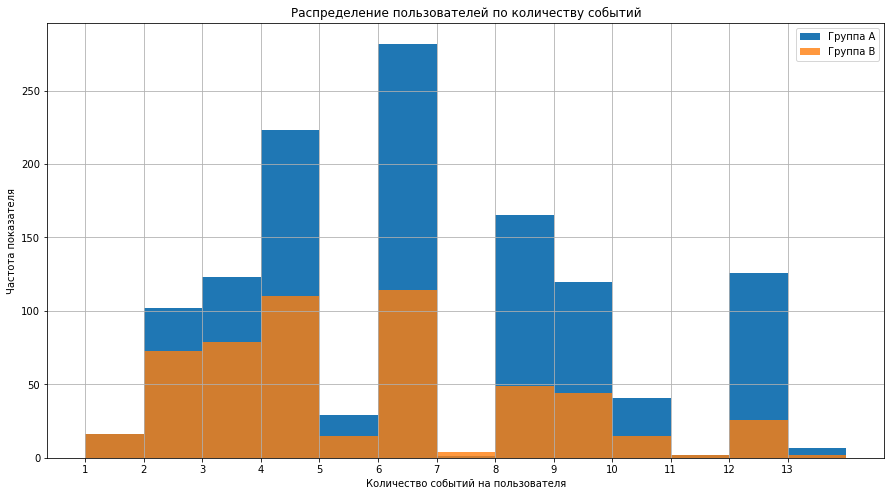

In [52]:
ax = (
    cnt_ev_by_users_a[cnt_ev_by_users_a['events_count'] <= np.percentile(count_events_by_users.events_count, 95)]
    .hist(bins=int(np.percentile(count_events_by_users.events_count, 95)) - 1, label='Группа A', figsize=(15,8))
)
(
    cnt_ev_by_users_b[cnt_ev_by_users_b['events_count'] <= np.percentile(count_events_by_users.events_count, 95)]
    .hist(bins=int(np.percentile(count_events_by_users.events_count, 95)) - 1,
          label= 'Группа B', alpha = 0.8, ax=ax)
)

plt.xlabel('Количество событий на пользователя')
plt.ylabel('Частота показателя')
plt.title('Распределение пользователей по количеству событий')
plt.xticks(range(1, int(np.percentile(count_events_by_users.events_count, 95))))
plt.legend()
plt.show()

Также построим гистограмму распределения количества событий на пользователя с указанием относительной частоты показателя.

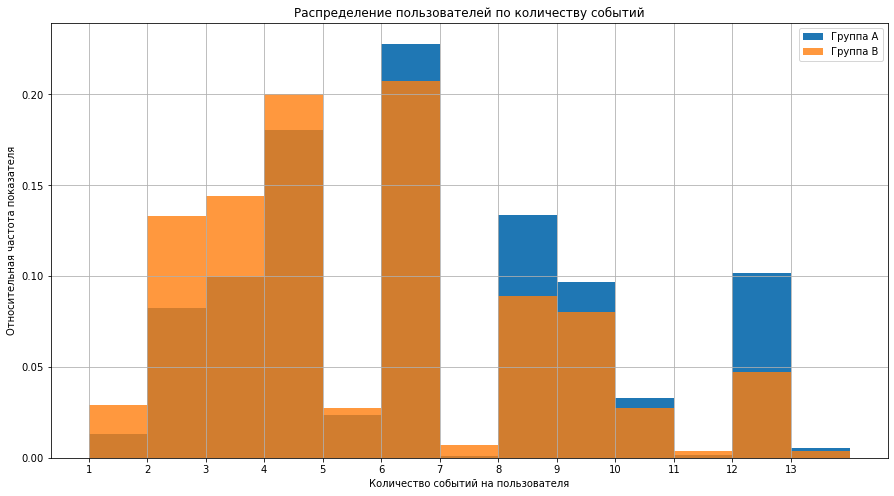

In [53]:
ax = (
    cnt_ev_by_users_a[cnt_ev_by_users_a['events_count'] <= np.percentile(count_events_by_users.events_count, 95)]
    .hist(bins=int(np.percentile(count_events_by_users.events_count, 95)) - 1, label='Группа A', figsize=(15,8), density=True)
)
(
    cnt_ev_by_users_b[cnt_ev_by_users_b['events_count'] <= np.percentile(count_events_by_users.events_count, 95)]
    .hist(bins=int(np.percentile(count_events_by_users.events_count, 95)) - 1,
          label= 'Группа B', alpha = 0.8, ax=ax, density=True)
)

plt.xlabel('Количество событий на пользователя')
plt.ylabel('Относительная частота показателя')
plt.title('Распределение пользователей по количеству событий')
plt.xticks(range(1, int(np.percentile(count_events_by_users.events_count, 95))))
plt.legend()
plt.show()

**Вывод:** В группе А чаще, чем в В встречаются пользователи с количеством событий от 6 до 13. 

Посмотрим как число событий в выборках распределено по дням.

Для удобства в датасет `final_ab_events` добавим принадлежность пользователя той или иной группе теста.

In [54]:
final_ab_events = final_ab_events.merge(final_ab_participants[['user_id', 'group']], how='left', on='user_id') 
final_ab_events['event_dt_day'] = final_ab_events['event_dt'].dt.strftime('%Y-%m-%d')

In [55]:
final_ab_events

,user_id,event_dt,event_name,details,first_date,group,event_dt_day
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,A,2020-12-07
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,2020-12-07,A,2020-12-07
2,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,2020-12-07,B,2020-12-07
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,2020-12-07,A,2020-12-07
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,2020-12-07,B,2020-12-07
...,...,...,...,...,...,...,...
12232,A13A9A1B54CAEB4B,2020-12-29 14:59:38,login,NaN,2020-12-17,A,2020-12-29
12233,1095D37412647DA1,2020-12-29 02:27:25,login,NaN,2020-12-17,A,2020-12-29
12234,9F4F58990EAB3DFE,2020-12-29 17:39:13,login,NaN,2020-12-17,A,2020-12-29
12235,14AB9446E8FD3584,2020-12-29 00:09:48,login,NaN,2020-12-17,A,2020-12-29


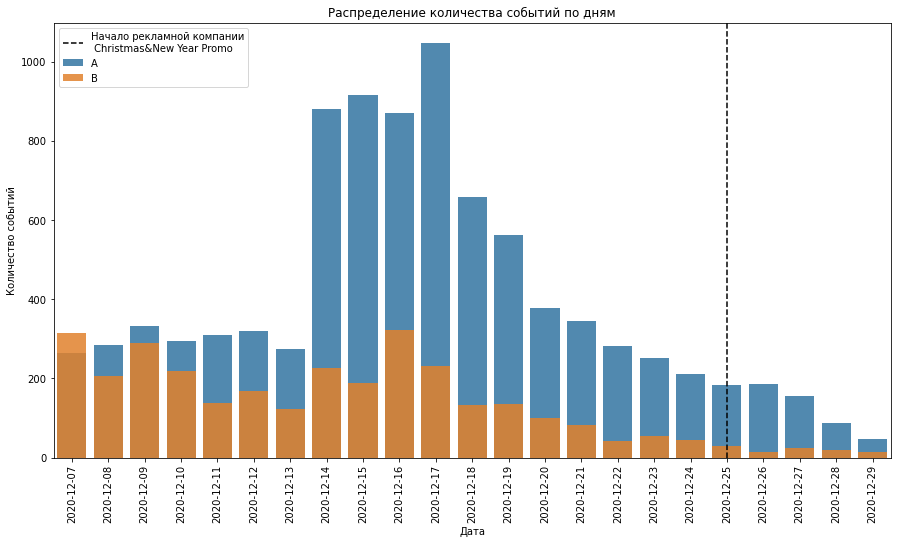

In [56]:
plt.figure(figsize=(15,8))
sns.countplot(data=final_ab_events, x='event_dt_day', hue='group', dodge=False, alpha=0.85)

plt.title('Распределение количества событий по дням')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.axvline(x=18, linestyle='--', color='black', label='Начало рекламной компании\n Christmas&New Year Promo')
plt.legend()
plt.show()

*Для пользователей группы А* количество событий относительно стабильно в период с 2020-12-07 по 2020-12-13, 2020-12-14 происходит резкий рост практически на 300%, до 2020-12-16 удерживается на максимальных значениях и затем резко снижается 2020-12-20. С 2020-12-21 по 2020-12-29 также происходит плавное снижение.  2020-12-30 пользователями из группы А не совершено ни одного действия.

Количество действий *пользователей группы В* падает с 2020-12-07 по 2020-12-13, затем наблюдается рост до 2020-12-16, 2020-12-17 падает практически на 50% и плавно снижается практически до 0 к 2020-12-30.
Также можно отметить, что рекламная компания Christmas&New Year Promo не повлияла на действия пользователей.

**Вывод:** распределение количества событий по дням неравномерно и имеет различия среди групп А и В.

Посмотрим, как меняется конверсия в воронке событий в выборках на разных этапах.

Очередность событий выглядит следующим образом:

- `login` - вход в систему
- `product_page` - просмотр страницы продукта
- `product_cart` - просмотр крорины
- `purchase` - совершение покупки

In [57]:
# сгруппируем пользователей по событиям и посчитаем их количество
events_by_group = (
    final_ab_events.groupby(['group', 'event_name'])['user_id'].nunique().to_frame()
    .rename(columns=({'user_id': 'user_count'})).reset_index()
)

# преобразуем и развернем таблицу
events_by_group = events_by_group.pivot(index='group', columns='event_name')['user_count'].T

# зададим логический порядок для сортировки
events_range= ['login', 'product_page', 'product_cart', 'purchase']

# отсортируем датафрейм
events_by_group = events_by_group.reset_index()
events_by_group.event_name = events_by_group.event_name.astype('category').cat.set_categories(events_range)
events_by_group = events_by_group.sort_values(['event_name']).set_index('event_name')


In [58]:
events_by_group

group,A,B
event_name,,
login,1321,558
product_page,843,311
product_cart,407,164
purchase,405,157


Построим воронки событий для групп А и В.

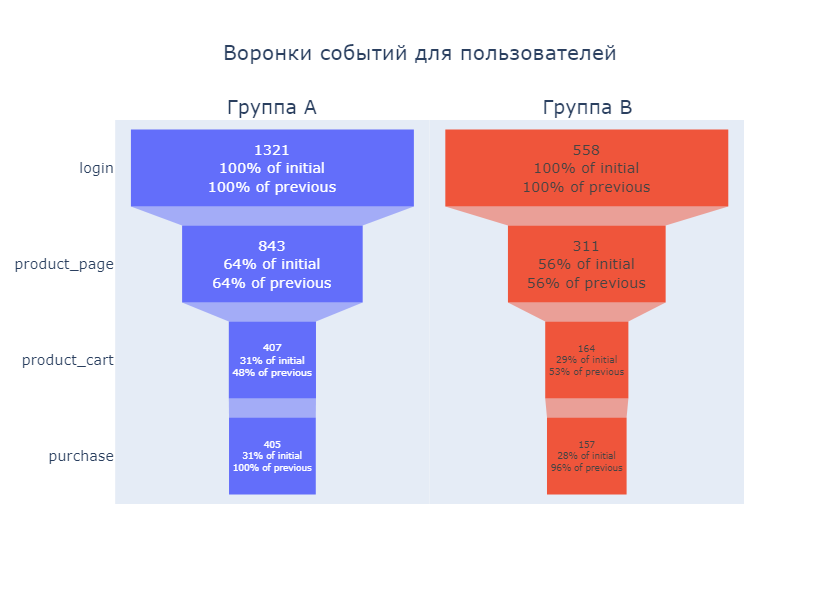

In [59]:
# Создаем сетку для вывода графиков, указываем тип графика и ширину столбцов для каждой ячейки. Также выводим название
fig = make_subplots(
    rows=1, cols=2, specs=[[{'type': 'funnel'}, {'type': 'funnel'}]], shared_yaxes=True,
    horizontal_spacing=0,
    subplot_titles=['Группа А', 'Группа В']
)

fig1 = go.Funnel(
    y=events_by_group.index, 
    x=events_by_group.A,
    textinfo = 'value+percent previous+percent initial',
    showlegend=False,
    textposition='inside'

)

fig2 = go.Funnel(
    y=events_by_group.index, 
    x=events_by_group.B,
    textinfo = 'value+percent previous+percent initial',
    showlegend=False,
    textposition='inside'
)

# Добавляем диаграммы на сетку
fig.add_trace(fig1, row=1, col=1)
fig.add_trace(fig2, row=1, col=2)
fig.update_layout(title=dict(text="Воронки событий для пользователей", x=0.5))

fig.show()

**Вывод:**
- конверсия в просмотр карточек товаров в группе А (64%) выше, чем в группе В (56%)
- конверсия с просмотра карточек товаров в переход в корзину в группе А (48%) ниже, чем в группе В (53%)
- после просмотра корзины практически все пользователи группы А совершают покупку, в группе В покупку совершают 96% пользователей
- в целом от входа в систему до покупки в группе А доходит больше пользователей (31%), чем в гурппе В (28%)
- в группе В доля пользователей, не совершавших действия (66%) значительно выше, чем в группе А (41%)

## Проверка результатов A/B тестирования

Проверим, находят ли статистические критерии разницу между группами А и В.

В ходе проверки гипотез будем искать различия в долях пользователей от их общего количества для определенного события. Поскольку мы тестируем работу рекомендательной системы, нас интересуют только пользователи, вошедшие в систему. Поэтому общее количество пользователей, от которого будем искать долю, будем определять по событию login.

Установим нулевую и альтернативную гипотезы:

 - H0 - разницы между группами нет, доли равны.
 - H1 - есть разница между группами, доли не равны.
 
Для статистических тестов зададим параметр статистической значимости *alpha* равным *0.05*. С учетом поправки Бонферони скорректируем параметр статистической значимости на количесвто проверок (3).

Для проверки разницы между различными группами создадим функцию `diff_share`, которая на вход будет принимать названия сравниваемых групп,  название события и критический уровень статистической значимости (по умолчанию 0.05). Функция возвращает p-value и результат проверки гипотезы (отвергаем или не отвергаем нулевую гипотезу).

In [60]:
def diff_share(data, group_one, group_two, item, total, alpha=.05):
    
    """Функция, которая проверяет статистическую разницу долей с помощью z-критерия
    
    Функция на вход принимает датасет, названия сравниваемых групп, название события, общее количество пользователей группы
    и критический уровень  статистической значимости (по умолчанию 0.05) и возвращает p-value и результат проверки гипотезы 
    (отвергаем или не отвергаем заданную нулевую гипотезу).
    """

    successes_users = np.array([data.loc[group_one, item], data.loc[group_two, item]])
    trials_users = np.array([data.loc[group_one, total], data.loc[group_two, total]])

    # пропорция успехов в первой группе:
    p1 = successes_users[0]/trials_users[0]

    # пропорция успехов во второй группе:
    p2 = successes_users[1]/trials_users[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes_users[0] + successes_users[1]) / (trials_users[0] + trials_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_users[0] + 1/trials_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('-'*30)
    print(f'Сравниваем доли пользователей групп {group_one} и {group_two} для события {item}.')
    print(f'p-значение: {round(p_value, 4)}.')
    print(f'alpha (критический уровень статистической значимости): {round(alpha, 3)}.')

    if p_value < alpha:
        return print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        return print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
    

Для каждого события выполним написанную выше функцию и посмотрим результат.

In [61]:
for i in events_by_group.T.columns[1:]:
    diff_share(events_by_group.T, 'A', 'B', i, events_by_group.T.columns[0], .05/3)

------------------------------
Сравниваем доли пользователей групп A и B для события product_page.
p-значение: 0.001.
alpha (критический уровень статистической значимости): 0.017.
Отвергаем нулевую гипотезу: между долями есть значимая разница.
------------------------------
Сравниваем доли пользователей групп A и B для события product_cart.
p-значение: 0.5411.
alpha (критический уровень статистической значимости): 0.017.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.
------------------------------
Сравниваем доли пользователей групп A и B для события purchase.
p-значение: 0.2752.
alpha (критический уровень статистической значимости): 0.017.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


**Вывод:** в результате проверки долей пользователей по каждому из событий (product_page, product_cart, purchase) с помощью z-критерия установлено, что статистически значимая разница (при заданном критическом уровне статзначимости с учетом поправки Бонферони 1.67%) в долях пользователей присутствует только для события *просмотра страницы продукта*.

## Общий вывод

В результате исследования выполнена оценка корректности проведения теста и проанализированы его результаты.

**Проверка данных на соответствие требованиям ТЗ**

*Техническое задание*

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платежная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
По результатам проверки установлено следующее:
1. Набор пользователей в группы проводился дольше (с 2020-12-07 по 2020-12-23), чем требуется в ТЗ (с 2020-12-07 по 2021-01-21)
2. По условиям ТЗ дата остановки теста: 2021-01-04. Тест остановлен 2020-12-30 - раньше запланированной даты
3. В тест отобрано 15% пользователей из региона EU
4. Количество участников теста: 6701

*Формально все требования ТЗ, за исключением даты окончания теста, выполняются. Однако часть пользователей, походящих под заданные условия могут не совершить действий за период проведения теста, а также могут участвовать в тестовой группе конкурирующего теста (то есть быть подверженным влиянию изменений конкурирующего теста).*

Однако окончание теста раньше запланированной даты (установленной с учетом набора необходимой аудитории и минимального обнаруживаемого изменения показателей)  может сделать результаты теста недействительными (не все зарегистрированные пользователи прожили требуемые 14 дней к моменту окончания теста, что сокращает его аудиторию).

Также стоит учитывать, что в период с 2020-12-25 по 2020-12-30 на поведение пользователей может оказывать влияние рекламная компания Christmas&New Year Promo.

**Исследование и подготовка данных для проведения анализа**

В ходе подготовки данных из датасета с участниками теста удалены пользователи, прожившие менее 14 дней к моменту окончания тестирования. 

Обнаружена и удалена часть участников теста, которые также состояли в тестовой группе конкурирующего теста (который мог оказывать влияние на поведение таких пользователей).

Среди отфильтрованных пользователей группы А 41% не совершали действий за время проведения тестирования, среди пользователей группы В - 66%.

По гистограмме распределения количества регистраций пользователей по дням установлено, что для группы А практически каждый день регистрировалось больше пользователей, чем для группы В.

в группу А пользователи, которые не совершали действий регистрировались с 2020-12-07 по 2020-12-12, причем за последнюю дату таких пользвователей зарегистрировалось большое количество. С 2020-12-12 пользователи, не совершавшие действий не регистрировались. В группу В пользователи, которые не совершали действий регистрировались на протяжении всего времени набора: с 2020-12-07 по 2020-12-16.

После подготовки данных разница между количеством пользователей групп А и В составляет 15.6%.

В процессе проверки качества теста и подготовки данных утрачено 42.26% пользователей.

Доля участников теста из Европы среди всех пользователей, зарегистрировавшихся в период с 2020-12-07 по 2020-12-16: 10.79%
Общее количество участников теста: 3869.

*Фактически требования ТЗ не выполняются.*

**Исследовательский анализ данных**

Очередность событий выглядит следующим образом:

- `login` - вход в систему
- `product_page` - просмотр страницы продукта
- `product_cart` - просмотр крорины
- `purchase` - совершение покупки

В группе А чаще, чем в В встречаются пользователи с количеством событий от 6 до 13. Распределение количества событий по дням неравномерно и имеет различия среди групп А и В.

Для пользователей группы А количество событий относительно стабильно в период с 2020-12-07 по 2020-12-13, 2020-12-14 происходит резкий рост практически на 300%, до 2020-12-16 удерживается на максимальных значениях и затем резко снижается 2020-12-20. С 2020-12-21 по 2020-12-29 также происходит плавное снижение. 2020-12-30 пользователями из группы А не совершено ни одного действия.

Количество действий пользователей группы В падает с 2020-12-07 по 2020-12-13, затем наблюдается рост до 2020-12-16, 2020-12-17 падает практически на 50% и плавно снижается практически до 0 к 2020-12-30. Также можно отметить, что рекламная компания Christmas&New Year Promo не повлияла на действия пользователей.

**Сравнение конверсий пользователей групп А и В**
- конверсия в просмотр карточек товаров в группе А (64%) выше, чем в группе В (56%)
- конверсия с просмотра карточек товаров в переход в корзину в группе А (48%) ниже, чем в группе В (53%)
- после просмотра корзины практически все пользователи группы А совершают покупку, в группе В покупку совершают 96% пользователей
- в целом от входа в систему до покупки в группе А доходит больше пользователей (31%), чем в гурппе В (28%)
- в группе В доля пользователей, не совершавших действия (66%) значительно выше, чем в группе А (41%)

**Проверка результатов А/В тестирования**

В результате проверки долей пользователей по каждому из событий (product_page, product_cart, purchase) с помощью z-критерия установлено, что статистически значимая разница (при заданном критическом уровне статзначимости с учетом поправки Бонферони 1.67%) в долях пользователей присутствует только для события *просмотра страницы продукта*.

**Заключение по итогам исследования**

Доля участников теста имеет пересечение с тестовой группой конкурирующего теста. Тестирование завершено раньше запланированной даты.

**Тест следует признать недействительным, поскольку допущены ошибки при его проведении, которые могут значительно исказить результаты тестирования. Для выявления влияния новой рекомендательной системы на поведение пользователей провести новый тест.**

*Рекомендации*

При проведении тестирования необходимо исключить пересечения участников теста с тестовой группой конкурирующих тестов, также по возможности исключить пересечение времени проведения тестирования с маркетинговыми событиями.

Для коректного разбиения пользователей по группам целесообразно настроить алгоритм распределения таким образом, чтобы не допустить значительного перекоса по количеству пользователей в группах.

Завершать тест следует не раньше запланированной даты.